In [1]:
from pyspark import SparkContext, SparkConf
import pandas as pd
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import os
import sklearn as skl
#day of week börjar på söndag så söndag = 1

In [2]:
conf = SparkConf().setAppName('project')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=project>

In [3]:
sc.version

'3.0.2'

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('project').config('spark.some.config.option', "some-value").getOrCreate()

In [5]:
def cast_columns(df, value_type):
    df = df.withColumn("month",df.month.cast('int'))
    df = df.withColumn("date",df.date.cast('int'))
    df = df.withColumn("value",df.value.cast(value_type))
    df = df.withColumn("hour",df.hour.cast('int'))
    df = df.withColumn("minute",df.minute.cast('int'))
    df = df.withColumn("weekday",df.weekday.cast('int'))
    return df

## Supervised

In [24]:
df_couch = spark.read.csv('int_sensor_compressed/livingroom-couch-pressure.csv', header=True)
df_livingmotion = spark.read.csv('int_sensor_compressed/livingroom-ambience-motion.csv', header=True)
df_livinglight = spark.read.csv('int_sensor_compressed/livingroom-tv-light.csv', header=True)


df_couchpd = df_couch.toPandas()
df_livingmotionpd = df_livingmotion.toPandas()
df_livinglightpd = df_livinglight.toPandas()
df_couchpd['value'] = pd.to_numeric(df_couchpd['value'])
df_livingmotionpd['value'] = pd.to_numeric(df_livingmotionpd['value'])
df_livinglightpd['value'] = pd.to_numeric(df_livinglightpd['value'])

df_couchpd['couch_label'] = df_couchpd['value']#.apply(lambda x: 1 if x > 300 else 0)
df_livingmotionpd['lrm_label'] = df_livingmotionpd['value']#.apply(lambda x: 1 if x==1 else 0)
df_livinglightpd['lrl_label'] = df_livinglightpd['value']#.apply(lambda x: 1 if x < 1024 else 0)

dropped_columns = ['sensor_id','year','month', 'date','hour', 'minute', 'second','weekday', 'week', 'value']
df_couchpd = df_couchpd.drop(columns=dropped_columns)
df_livingmotionpd = df_livingmotionpd.drop(columns=dropped_columns)
df_livinglightpd = df_livinglightpd.drop(columns=dropped_columns)


df_total = df_couchpd.merge(df_livinglightpd, on='timestamp')\
            .merge(df_livingmotionpd, on='timestamp')

df_total = df_total.drop(columns = 'timestamp')

In [25]:
data = np.array(df_total)

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(data)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++',n_clusters=2)
kmeans.fit(reduced_data)
kmeans_preds = kmeans.predict(reduced_data)

[Text(465.0, 755.0, 'X[0] <= 1.292\ngini = 0.148\nsamples = 699411\nvalue = [643055, 56356]'),
 Text(232.5, 453.0, 'X[1] <= 3.325\ngini = 0.009\nsamples = 645563\nvalue = [642611, 2952]'),
 Text(116.25, 151.0, 'gini = 0.0\nsamples = 642622\nvalue = [642611, 11]'),
 Text(348.75, 151.0, 'gini = 0.0\nsamples = 2941\nvalue = [0, 2941]'),
 Text(697.5, 453.0, 'X[0] <= 1.403\ngini = 0.016\nsamples = 53848\nvalue = [444, 53404]'),
 Text(581.25, 151.0, 'gini = 0.399\nsamples = 468\nvalue = [129, 339]'),
 Text(813.75, 151.0, 'gini = 0.012\nsamples = 53380\nvalue = [315, 53065]')]

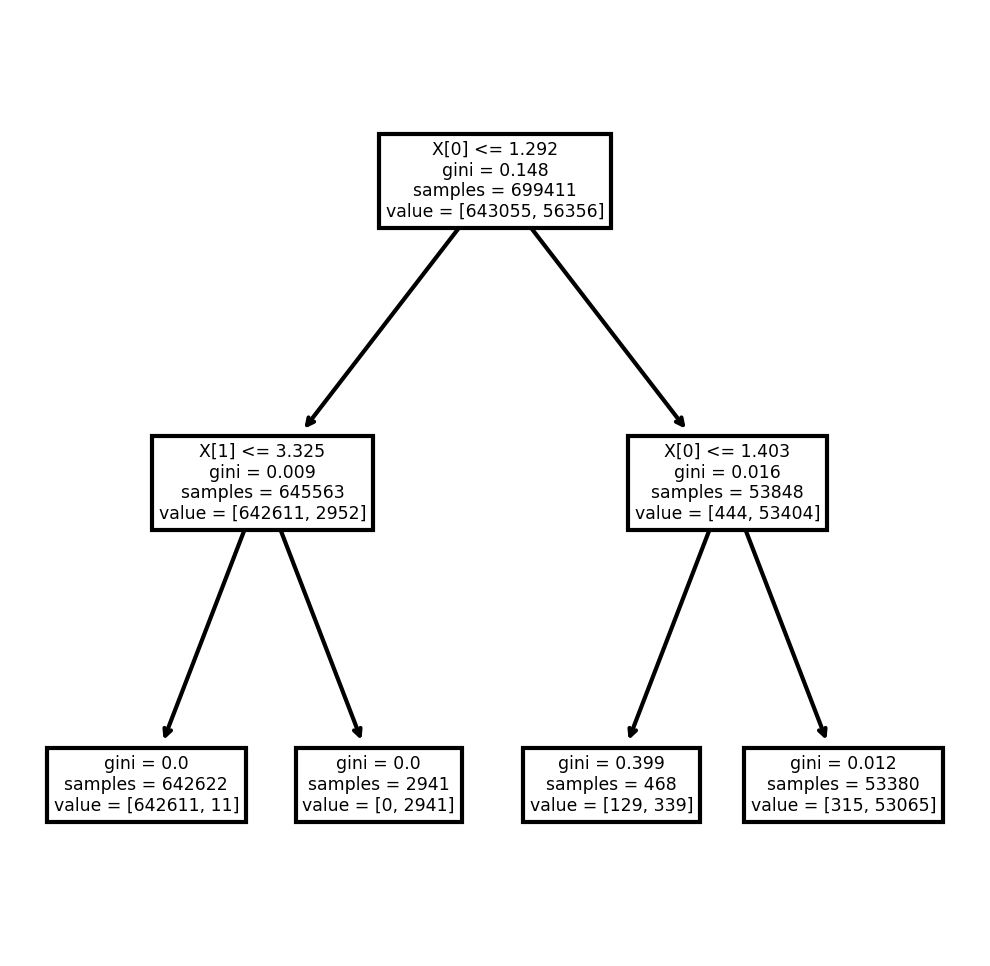

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

dtree = DecisionTreeClassifier(max_depth=2)
xtrain, xtest, ytrain, ytest = train_test_split(reduced_data, kmeans_preds, test_size = 0.2, random_state=42)
clf = dtree.fit(xtrain, ytrain)
fig, axes = plt.subplots(1,1,figsize=(4,4), dpi=300)
tree.plot_tree(dtree)
#fig.savefig('tree.png')

In [39]:
predictions = clf.predict(xtest)
print('Decision tree acuracy:', np.mean(ytest == predictions))

Decision tree acuracy: 0.9994395292045318


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(reduced_data, kmeans_preds, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [42]:
print('Naive Bayes acuracy:', np.mean(y_test == y_pred))

Naive Bayes acuracy: 0.9998627418460078
